In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

## POYO within-sess

### Processing all within-session csvs
within-sess validation results csv for all sessions

Combine them into one csv for further analysis

In [2]:
def get_filenames_from_path(path):
    if os.path.exists(path):
        if os.path.isdir(path):
            filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
            return filenames
        else:
            return [os.path.basename(path)]
    else:
        return []

#Helper function to get nwbfile names, session ids and corresponding ROI numbers (same order)
def getNWBinfo(mouse_csv_path='/home/mila/x/xuejing.pan/thesis/mouse_df.csv'):
        lines = []
        sess_ids = []
        planes = []
	
        df = pd.read_csv(mouse_csv_path, usecols = ['sessid','line','runtype','plane'])

        #Getting all prod data
        for row, curr_type in enumerate(df.runtype):
            if curr_type == 'prod': 
                lines.append(df.line[row])
                sess_ids.append(df.sessid[row])
                planes.append(df.plane[row])
        
        assert len(lines)==len(sess_ids)==len(planes)==50, "Error in getting session info." 

        return sess_ids, planes, lines

In [3]:
val_csv_path = '/home/mila/x/xuejing.pan/POYO/results/cross_sess/val'
#train_csv_path = '/home/mila/x/xuejing.pan/POYO/results/within-sess/train'
mouse_csv = '/home/mila/x/xuejing.pan/POYO/project-kirby/mouse_df.csv'
#get all sessions
all_sessions = [
        "758519303","759189643" "759660390" "759666166" "759872185",
        "760269100","761730740","762415169","763646681","761624763", 
        "761944562","762250376","760260459","760659782","761269197", 
        "763949859","764897534","765427689","766755831","767254594",
        "768807532","764704289","765193831","766502238","777496949", 
        "778374308","779152062","777914830","778864809","779650018",
        "826187862","826773996","827833392","826338612","826819032", 
        "828816509","829283315","823453391","824434038","825180479", 
        "826659257","827300090","828475005","829520904","832883243", 
        "833704570","834403597","836968429","837360280","838633305" 
        ]

In [4]:
sess_ids, planes, lines = getNWBinfo(mouse_csv)

#creating a combined csv for validation information
combined_val_df_columns = ["sess_id", "epoch", "val_accs", "line", "plane"]
combined_val_df = pd.DataFrame(columns=combined_val_df_columns)

all_epochs = 0

for idx, curr_sess_id in enumerate(sess_ids):
    #for each session
    curr_plane = planes[idx]
    curr_line = lines[idx]

    file_path = os.path.join(val_csv_path,'val_{}.csv'.format(str(curr_sess_id)))
    #curr_df = pd.read_csv(file_path, usecols=["Step", "{} - val/session_{}_accuracy_gabor_orientation".format(str(curr_sess_id),str(curr_sess_id))])
    curr_df = pd.read_csv(file_path, usecols=["epoch", "IMPORTANT - multi_sess - val/session_{}_accuracy_gabor_orientation".format(str(curr_sess_id))])
    
    
    #epochs = curr_df["Step"]
    #epochs = epochs/17.2
    epochs = curr_df["epoch"]
    all_epochs = epochs
    
    #val_accs = curr_df["{} - val/session_{}_accuracy_gabor_orientation".format(str(curr_sess_id),str(curr_sess_id))]
    val_accs = curr_df["IMPORTANT - multi_sess - val/session_{}_accuracy_gabor_orientation".format(str(curr_sess_id))]

    for count, epoch in enumerate(epochs):
        combined_val_df = combined_val_df.append({
            "sess_id": int(curr_sess_id),
            "line": curr_line,
            "plane": curr_plane,
            "epoch": int(epoch),
            "val_accs": float(val_accs[count]),
            },
        ignore_index=True)


FileNotFoundError: [Errno 2] No such file or directory: '/home/mila/x/xuejing.pan/POYO/results/cross_sess/val/val_758519303.csv'

In [45]:
combined_train_df_columns = ["sess_id", "epoch", "train_losses", "line", "plane"]
combined_train_df = pd.DataFrame(columns=combined_train_df_columns)

for idx, curr_sess_id in enumerate(sess_ids):
    #for each session
    curr_plane = planes[idx]
    curr_line = lines[idx]

    #file_path = os.path.join(val_csv_path,'train_losses.csv')
    file_path = os.path.join(val_csv_path, 'train_{}.csv'.format(str(curr_sess_id)))
    curr_df = pd.read_csv(file_path)
    #epochs = curr_df["epoch"]
    train_loss = curr_df["{} - train_loss".format(str(curr_sess_id))]

    epochs = curr_df["epoch"]
    all_epochs = epochs

    for count, epoch in enumerate(epochs):
        combined_train_df = combined_train_df.append({
            "sess_id": int(curr_sess_id),
            "line": curr_line,
            "plane": curr_plane,
            "epoch": int(epoch),
            "train_losses": float(train_loss[count]),
            },
        ignore_index=True)

In [23]:
#save csv 
combined_val_df.to_csv(os.path.join(val_csv_path,'combined_vals.csv'))

In [46]:
combined_train_df.to_csv(os.path.join(val_csv_path,'combined_train_losses.csv'))

### use combined_val_df and combined_train_df to construct plots and do analysis


In [4]:
combined_val_df = pd.read_csv('/home/mila/x/xuejing.pan/POYO/results/within-sess/combined_vals.csv')

In [5]:
def get_acc_for_one_sess(combined_df,sess_id):
    condition = (combined_df["sess_id"] == sess_id)
    accs = combined_df.loc[condition,"val_accs"]

    condition_soma = (combined_df["sess_id"] == sess_id) &  (combined_df["plane"] == "soma")
    condition_dend = (combined_df["sess_id"] == sess_id) &  (combined_df["plane"] == "dend")
    condition_L23 = (combined_df["sess_id"] == sess_id) &  (combined_df["line"] == "L23-Cux2")
    condition_L5 = (combined_df["sess_id"] == sess_id) &  (combined_df["line"] == "L5-Rbp4")

    accs_soma = combined_df.loc[condition_soma,"val_accs"]
    accs_dend = combined_df.loc[condition_dend,"val_accs"]
    accs_L23 = combined_df.loc[condition_L23,"val_accs"]
    accs_L5 = combined_df.loc[condition_L5,"val_accs"]

    return accs,accs_dend,accs_soma,accs_L5,accs_L23

def get_losses_for_one_sess(combined_df,sess_id):
    condition = (combined_df["sess_id"] == sess_id)
    losses = combined_df.loc[condition,"train_losses"]

    condition_soma = (combined_df["sess_id"] == sess_id) &  (combined_df["plane"] == "soma")
    condition_dend = (combined_df["sess_id"] == sess_id) &  (combined_df["plane"] == "dend")
    condition_L23 = (combined_df["sess_id"] == sess_id) &  (combined_df["line"] == "L23-Cux2")
    condition_L5 = (combined_df["sess_id"] == sess_id) &  (combined_df["line"] == "L5-Rbp4")

    losses_soma = combined_df.loc[condition_soma,"train_losses"]
    losses_dend = combined_df.loc[condition_dend,"train_losses"]
    losses_L23 = combined_df.loc[condition_L23,"train_losses"]
    losses_L5 = combined_df.loc[condition_L5,"train_losses"]

    return losses,losses_dend,losses_soma, losses_L5, losses_L23

def get_acc_for_diff_types(combined_df):
    pass

In [6]:
def getNWBfilenames(mouse_csv_path='/home/mila/x/xuejing.pan/thesis/mouse_df.csv'):
    filenames = []
    sess_ids = []
    num_rois = []
    lines = []
    planes = []

    df = pd.read_csv(mouse_csv_path, usecols = ['sessid','mouseid','runtype','nrois','line','plane'])

    #Getting all prod data
    for row, curr_type in enumerate(df.runtype):
        if curr_type == 'prod': 
            #f_name = source_dir+"/sub-"+str(df.mouseid[row])+"_ses-"+str(df.sessid[row])+"_obj-raw_behavior+image+ophys.nwb"
            f_name = "sub-"+str(df.mouseid[row])+"_ses-"+str(df.sessid[row])+"_obj-raw_behavior+image+ophys.nwb"
            filenames.append(f_name)
            sess_ids.append(df.sessid[row])
            num_rois.append(df.nrois[row])
            lines.append(df.line[row])
            planes.append(df.plane[row])

    return filenames,sess_ids, num_rois, lines, planes

def check_nan(array):
    nan_indices = np.isnan(array)

    if np.any(nan_indices):
        non_nan_indices = ~nan_indices
        x = np.where(non_nan_indices)[0]
        y = array[non_nan_indices]
        
        # Use interpolation only if there are non-NaN values
        if len(x) > 0:
            f = interpolate.interp1d(x, y, kind='linear', fill_value='extrapolate')
            array[nan_indices] = f(np.where(nan_indices)[0])

    return array

def get_cont_labels(nwbfile):
    behavior_module = nwbfile.processing['behavior']
    BehavioralTimeSeries= behavior_module.get_data_interface('BehavioralTimeSeries')
    pupiltracking = behavior_module.get_data_interface('PupilTracking')
    pupil_diameter = pupiltracking.time_series['pupil_diameter']
    pupil_diameter_data = np.copy(pupil_diameter.data)
    pupil_diameter_data = check_nan(pupil_diameter_data)
    behavior_timestamps= pupil_diameter.timestamps # Same timestamps as roi

    return pupil_diameter_data

def calculate_accuracy(prediction, valid_discrete_label):
    if len(prediction) != len(valid_discrete_label):
        return "Error: Arrays have different lengths."

    matches = sum(p == v for p, v in zip(prediction, valid_discrete_label))
    accuracy = matches / len(prediction)
    return accuracy

def get_diff_sess_ids():
        filenames,sess_ids, num_rois, lines, planes = getNWBfilenames()
        dend_sess_ids = []
        soma_sess_ids = []
        L23_sess_ids  = []
        L5_sess_ids = []

        for count, curr_sess_id in enumerate(sess_ids):
                if planes[count] == 'soma':
                        soma_sess_ids.append(curr_sess_id)
                else:
                        dend_sess_ids.append(curr_sess_id)

                if lines[count] == 'L23-Cux2':
                        L23_sess_ids.append(curr_sess_id)
                else:
                        L5_sess_ids.append(curr_sess_id)
        
        return dend_sess_ids, soma_sess_ids, L23_sess_ids, L5_sess_ids

In [7]:
#Get all validation accs and put in a 2d np array (num_sess(50), num_epochs)
#epochs = combined_val_df["epoch"] #x-axis

accs_list = []
accs_dend_list = []
accs_soma_list = []
accs_L23_list = []
accs_L5_list = []

for sess_id in tqdm(sess_ids):
    accs,accs_dend,accs_soma,accs_L5,accs_L23 = get_acc_for_one_sess(combined_val_df,sess_id)
    #accs,accs_dend,accs_soma,accs_L5,accs_L23 = get_losses_for_one_sess(combined_train_df,sess_id)

    accs_list.append(accs)

    if len(accs_soma) != 0:
        accs_soma_list.append(accs_soma)
    else:
        accs_dend_list.append(accs_dend)
    
    if len(accs_L23) != 0:
        accs_L23_list.append(accs_L23)
    else:
        accs_L5_list.append(accs_L5)


NameError: name 'sess_ids' is not defined

In [10]:
accs_arr = np.array(accs_list)
accs_dend_arr = np.array(accs_dend_list)
accs_soma_arr = np.array(accs_soma_list)
accs_L23_arr = np.array(accs_L23_list)
accs_L5_arr = np.array(accs_L5_list)

#sanity check
assert accs_arr.shape[0] == 50, "err"
print(accs_dend_arr.shape)
assert accs_dend_arr.shape[0] == 28, "err:dend"
assert accs_soma_arr.shape[0] == 22, "err:soma"
assert accs_L5_arr.shape[0] == 26, "err:L5"
assert accs_L23_arr.shape[0] == 24, "err:L23"


assert accs_arr.shape[1]==accs_dend_arr.shape[1]==accs_soma_arr.shape[1]==accs_L5_arr.shape[1], "err: epoch"

(28, 70)


In [14]:
accs_arr_last = accs_arr[:,-1]
print(accs_arr_last)

[0.83823532 0.65441179 0.60294116 0.31617647 0.44117647 0.375
 0.61764705 0.67647058 0.72058821 0.92647058 0.75735295 0.64705884
 0.72058821 0.5147059  0.67647058 0.89705884 0.68382353 0.85294116
 0.63235295 0.64705884 0.5        0.42647058 0.58823532 0.58823532
 0.41911766 0.4852941  0.69117647 0.4852941  0.30882353 0.25
 0.41176471 0.63235295 0.30882353 0.58088237 0.47794119 0.34558824
 0.33823529 0.58823532 0.78676468 0.78676468 0.82352942 0.625
 0.79411763 0.8602941  0.84558821 0.90441179 0.94117647 0.85294116
 0.8897059  0.27941176]


In [16]:
filenames,sess_ids, num_rois, lines, planes = getNWBfilenames()
def get_mean_std(accs_arr):
    accs_std = np.std(accs_arr)
    accs_avg = np.mean(accs_arr)

    print("all_std: ",accs_std)
    print("all_avg: ",accs_avg)


    dend_accs = []
    soma_accs = []

    for count, curr_sess_id in enumerate(sess_ids):
        if planes[count] == "soma":
            soma_accs.append(accs_arr[count])
        else:
            dend_accs.append(accs_arr[count])

    dend_accs = np.array(dend_accs)
    soma_accs = np.array(soma_accs)

    accs_soma_std = np.std(soma_accs)
    accs_soma_avg = np.mean(soma_accs)
    accs_dend_std = np.std(dend_accs)
    accs_dend_avg = np.mean(dend_accs)

    print("soma std: ",accs_soma_std)
    print("soma avg: ",accs_soma_avg)
    print("dend std: ",accs_dend_std)
    print("dend avg: ",accs_dend_avg)

In [17]:
get_mean_std(accs_arr_last)

all_std:  0.19342993024454921
all_avg:  0.6202941179275513
soma std:  0.17263468883647312
soma avg:  0.7159090909090909
dend std:  0.1748405340124064
soma avg:  0.5451680677277702


In [16]:
#Average for epochs for all sessions
accs_arr_avg = np.mean(accs_arr, axis = 0)
print(accs_arr_avg.shape)

(100,)


In [17]:
#avg for each category
accs_dend_arr_avg= np.mean(accs_dend_arr, axis=0)
accs_soma_arr_avg= np.mean(accs_soma_arr, axis=0)
accs_L23_arr_avg= np.mean(accs_L23_arr, axis=0)
accs_L5_arr_avg= np.mean(accs_L5_arr, axis=0)

In [18]:
print(accs_arr_avg[-1])
print(accs_dend_arr_avg[-1])
print(accs_soma_arr_avg[-1])
print(accs_L23_arr_avg[-1])
print(accs_L5_arr_avg[-1])

0.7498529410362244
0.7762605058295386
0.7162433131174608
0.7882965691387653
0.7143665150954173


In [32]:
#Getting train data
train_df = pd.read_csv("/home/mila/x/xuejing.pan/POYO/results/cross_sess/multi_sess_train_losses.csv", usecols=["epoch","IMPORTANT - multi_sess - train_loss"])
train_losses = train_df["IMPORTANT - multi_sess - train_loss"]
train_epochs = train_df["epoch"]

In [52]:
# Function to apply moving average to data
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Smoothing the data using a moving average with window size 5
smoothed_accs_arr_avg = moving_average(accs_arr_avg, 5)
smoothed_accs_dend_arr_avg = moving_average(accs_dend_arr_avg, 5)
smoothed_accs_soma_arr_avg = moving_average(accs_soma_arr_avg, 5)
smoothed_accs_L23_arr_avg = moving_average(accs_L23_arr_avg, 5)
smoothed_accs_L5_arr_avg = moving_average(accs_L5_arr_avg, 5)

### Plots

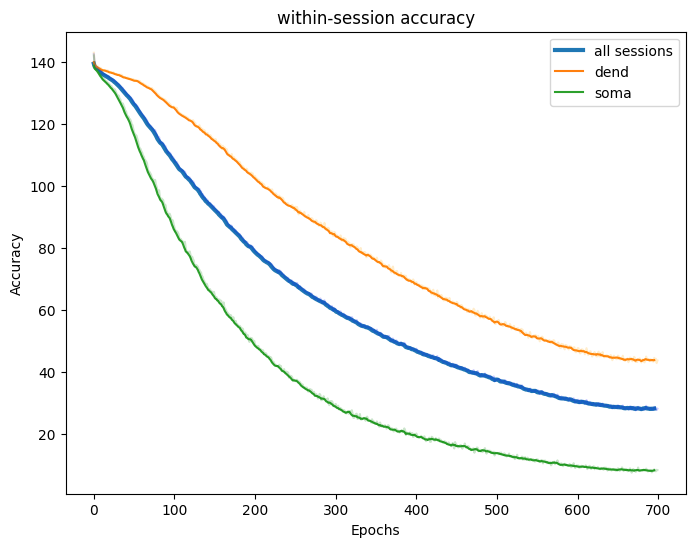

In [53]:
# Plotting the original and smoothed lines
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.plot(epochs[:len(smoothed_accs_arr_avg)], smoothed_accs_arr_avg*100, label='all sessions', linewidth=3)
plt.plot(epochs[:len(smoothed_accs_dend_arr_avg)], smoothed_accs_dend_arr_avg*100, label='dend')
plt.plot(epochs[:len(smoothed_accs_soma_arr_avg)], smoothed_accs_soma_arr_avg*100, label='soma')
#plt.plot(epochs[:len(smoothed_accs_L23_arr_avg)], smoothed_accs_L23_arr_avg*100, label='L2/3')
#plt.plot(epochs[:len(smoothed_accs_L5_arr_avg)], smoothed_accs_L5_arr_avg*100, label='L5')


# Plotting the original data as scatter plots
plt.plot(epochs, accs_arr_avg*100,color="blue", alpha=0.2)
plt.plot(epochs, accs_dend_arr_avg*100,color = "orange", alpha = 0.2)
plt.plot(epochs, accs_soma_arr_avg*100,color="green", alpha=0.2)
#plt.plot(epochs, accs_L23_arr_avg*100, alpha=0.2)
#plt.plot(epochs, accs_L5_arr_avg*100, alpha=0.2)

# Annotating final values of smoothed arrays
#plt.text(len(smoothed_accs_arr_avg) - 1, smoothed_accs_arr_avg[-1], f"{smoothed_accs_arr_avg[-1]:.2f}")
#plt.text(len(smoothed_accs_dend_arr_avg) - 1, smoothed_accs_dend_arr_avg[-1], f"{smoothed_accs_dend_arr_avg[-1]:.2f}")
#plt.text(len(smoothed_accs_soma_arr_avg) - 1, smoothed_accs_soma_arr_avg[-1], f"{smoothed_accs_soma_arr_avg[-1]:.2f}")
#plt.text(len(smoothed_accs_L23_arr_avg) - 1, smoothed_accs_L23_arr_avg[-1], f"{smoothed_accs_L23_arr_avg[-1]:.2f}")
#plt.text(len(smoothed_accs_L5_arr_avg) - 1, smoothed_accs_L5_arr_avg[-1], f"{smoothed_accs_L5_arr_avg[-1]:.2f}")

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('within-session accuracy')

# Adding grid and setting y-axis ticks
#plt.grid(True)
#plt.yticks(np.arange(0.25, 0.9, 0.05))

# Adding legend
plt.legend()

# Show plot
plt.show()

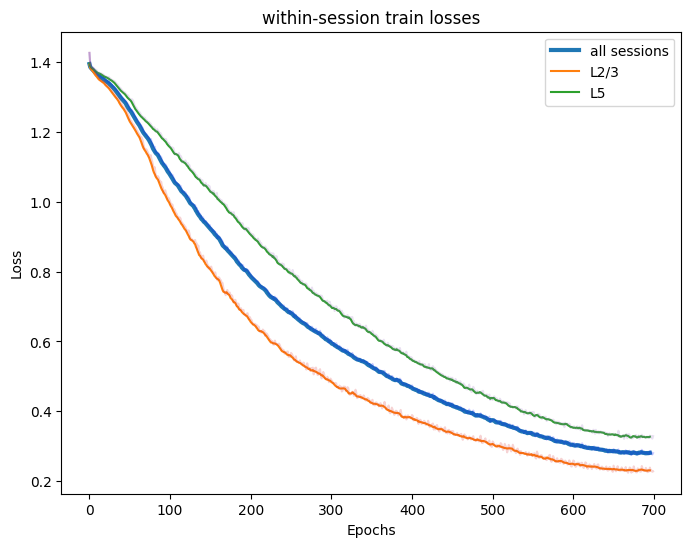

In [63]:
# Plotting the original and smoothed lines
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.plot(epochs[:len(smoothed_accs_arr_avg)], smoothed_accs_arr_avg, label='all sessions', linewidth=3)
#plt.plot(epochs[:len(smoothed_accs_dend_arr_avg)], smoothed_accs_dend_arr_avg, label='dend')
#plt.plot(epochs[:len(smoothed_accs_soma_arr_avg)], smoothed_accs_soma_arr_avg, label='soma')
plt.plot(epochs[:len(smoothed_accs_L23_arr_avg)], smoothed_accs_L23_arr_avg, label='L2/3')
plt.plot(epochs[:len(smoothed_accs_L5_arr_avg)], smoothed_accs_L5_arr_avg, label='L5')


# Plotting the original data as scatter plots
plt.plot(epochs, accs_arr_avg,color="blue", alpha=0.2)
#plt.plot(epochs, accs_dend_arr_avg,color = "orange", alpha = 0.2)
#plt.plot(epochs, accs_soma_arr_avg,color="green", alpha=0.2)
plt.plot(epochs, accs_L23_arr_avg, alpha=0.2)
plt.plot(epochs, accs_L5_arr_avg, alpha=0.2)

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('within-session train losses')

# Adding grid and setting y-axis ticks
#plt.grid(True)
#plt.yticks(np.arange(0.25, 0.9, 0.05))

# Adding legend
plt.legend()

# Show plot
plt.show()

## MLP results

In [7]:
def getNWBfilenames(mouse_csv_path='/home/mila/x/xuejing.pan/thesis/mouse_df.csv'):
    filenames = []
    sess_ids = []
    num_rois = []
    lines = []
    planes = []

    df = pd.read_csv(mouse_csv_path, usecols = ['sessid','mouseid','runtype','nrois','line','plane'])

    #Getting all prod data
    for row, curr_type in enumerate(df.runtype):
        if curr_type == 'prod': 
            #f_name = source_dir+"/sub-"+str(df.mouseid[row])+"_ses-"+str(df.sessid[row])+"_obj-raw_behavior+image+ophys.nwb"
            f_name = "sub-"+str(df.mouseid[row])+"_ses-"+str(df.sessid[row])+"_obj-raw_behavior+image+ophys.nwb"
            filenames.append(f_name)
            sess_ids.append(df.sessid[row])
            num_rois.append(df.nrois[row])
            lines.append(df.line[row])
            planes.append(df.plane[row])

    return filenames,sess_ids, num_rois, lines, planes

def check_nan(array):
    nan_indices = np.isnan(array)

    if np.any(nan_indices):
        non_nan_indices = ~nan_indices
        x = np.where(non_nan_indices)[0]
        y = array[non_nan_indices]
        
        # Use interpolation only if there are non-NaN values
        if len(x) > 0:
            f = interpolate.interp1d(x, y, kind='linear', fill_value='extrapolate')
            array[nan_indices] = f(np.where(nan_indices)[0])

    return array

def get_cont_labels(nwbfile):
    behavior_module = nwbfile.processing['behavior']
    BehavioralTimeSeries= behavior_module.get_data_interface('BehavioralTimeSeries')
    pupiltracking = behavior_module.get_data_interface('PupilTracking')
    pupil_diameter = pupiltracking.time_series['pupil_diameter']
    pupil_diameter_data = np.copy(pupil_diameter.data)
    pupil_diameter_data = check_nan(pupil_diameter_data)
    behavior_timestamps= pupil_diameter.timestamps # Same timestamps as roi

    return pupil_diameter_data

def calculate_accuracy(prediction, valid_discrete_label):
    if len(prediction) != len(valid_discrete_label):
        return "Error: Arrays have different lengths."

    matches = sum(p == v for p, v in zip(prediction, valid_discrete_label))
    accuracy = matches / len(prediction)
    return accuracy

def get_diff_sess_ids():
        filenames,sess_ids, num_rois, lines, planes = getNWBfilenames()
        dend_sess_ids = []
        soma_sess_ids = []
        L23_sess_ids  = []
        L5_sess_ids = []

        for count, curr_sess_id in enumerate(sess_ids):
                if planes[count] == 'soma':
                        soma_sess_ids.append(curr_sess_id)
                else:
                        dend_sess_ids.append(curr_sess_id)

                if lines[count] == 'L23-Cux2':
                        L23_sess_ids.append(curr_sess_id)
                else:
                        L5_sess_ids.append(curr_sess_id)
        
        return dend_sess_ids, soma_sess_ids, L23_sess_ids, L5_sess_ids

In [8]:
mlp_df = pd.read_csv('/home/mila/x/xuejing.pan/POYO/results/grid_search_results_w:info.csv')
filenames,sess_ids, num_rois, lines, planes = getNWBfilenames()

In [9]:
sess_ids_wrong_orders = mlp_df["sess_id"].values
accs_wrong_orders = mlp_df["best_test_acc"].values

In [17]:
accs_all = []

for count, curr_sess_id in enumerate(sess_ids):
    idx = np.where(sess_ids_wrong_orders == curr_sess_id)
    accs_all.append(accs_wrong_orders[idx])

accs_all = np.array(accs_all).reshape(50,)

In [19]:
accs_all

array([83.45588235, 76.47058824, 75.73529412, 67.64705882, 63.60294118,
       56.98529412, 73.52941176, 81.61764706, 71.69117647, 94.48529412,
       81.25      , 71.32352941, 78.67647059, 51.10294118, 72.79411765,
       93.75      , 78.30882353, 84.55882353, 77.20588235, 68.75      ,
       71.32352941, 72.42647059, 77.57352941, 77.57352941, 44.48529412,
       52.94117647, 68.38235294, 58.08823529, 51.83823529, 56.25      ,
       83.82352941, 83.08823529, 73.52941176, 88.97058824, 76.10294118,
       75.        , 63.23529412, 84.55882353, 86.39705882, 92.27941176,
       80.88235294, 65.07352941, 83.08823529, 83.45588235, 88.97058824,
       94.48529412, 94.48529412, 90.80882353, 93.38235294, 31.25      ])

In [6]:

def get_mean_std(accs_arr):
    accs_std = np.std(accs_arr)
    accs_avg = np.mean(accs_arr)

    print("all_std: ",accs_std)
    print("all_avg: ",accs_avg)


    dend_accs = []
    soma_accs = []

    for count, curr_sess_id in enumerate(sess_ids):
        if planes[count] == "soma":
            soma_accs.append(accs_arr[count])
        else:
            dend_accs.append(accs_arr[count])

    dend_accs = np.array(dend_accs)
    soma_accs = np.array(soma_accs)

    accs_soma_std = np.std(soma_accs)
    accs_soma_avg = np.mean(soma_accs)
    accs_dend_std = np.std(dend_accs)
    accs_dend_avg = np.mean(dend_accs)

    print("soma std: ",accs_soma_std)
    print("soma avg: ",accs_soma_avg)
    print("dend std: ",accs_dend_std)
    print("soma avg: ",accs_dend_avg)

In [34]:
get_mean_std(accs_all)

all_std:  13.823468788978465
all_avg:  74.93382352941178
soma std:  16.897697974006867
soma avg:  75.31751336898397
dend std:  10.801657574277783
soma avg:  74.63235294117648
